In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline

# Data preparation

In [3]:
df_covid_cases  = pd.read_csv("../data/time_series_covid19_confirmed_global.csv")
df_covid_deaths = pd.read_csv("../data/time_series_covid19_deaths_global.csv")

df_covid_cases = df_covid_cases.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
df_covid_deaths = df_covid_deaths.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()

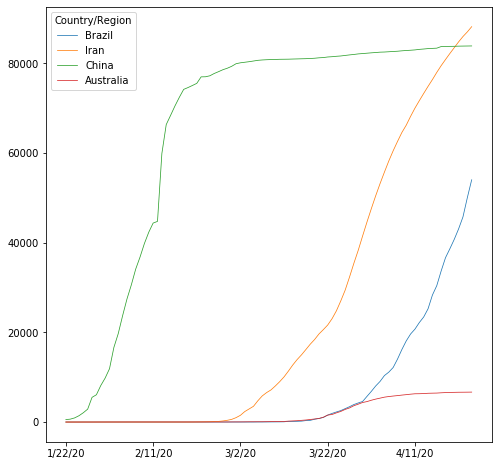

In [4]:
ax = df_covid_cases.loc[["Brazil", "Iran", "China", "Australia"], :].transpose().plot(figsize=(8,8), linewidth=0.75)

In [5]:
_first_case  = df_covid_cases[df_covid_cases>0].idxmin(axis=1)
_100_case   = df_covid_cases[df_covid_cases>99].idxmin(axis=1)
_1000_case  = df_covid_cases[df_covid_cases>999].idxmin(axis=1)
_10000_case = df_covid_cases[df_covid_cases>9990].idxmin(axis=1)
_total_cases = df_covid_cases["4/24/20"]

_first_death  = df_covid_deaths[df_covid_deaths>0].idxmin(axis=1)
_100_death   = df_covid_deaths[df_covid_deaths>99].idxmin(axis=1)
_1000_death  = df_covid_deaths[df_covid_deaths>999].idxmin(axis=1)
_10000_death = df_covid_deaths[df_covid_deaths>9990].idxmin(axis=1)
_total_death = df_covid_deaths["4/24/20"]

In [6]:
df_stats = pd.concat([_first_case, _100_case, _1000_case, _10000_case,_first_death, _100_death, _1000_death, _10000_death], axis=1)
df_stats.columns = ["first_case", "100_cases", "1000_cases", "10000_cases", "first_death", "100_deaths", "1000_deaths", "10000_deaths"]
df_stats = df_stats.applymap(lambda x: (dt.datetime.strptime(x, "%m/%d/%y").date()-dt.date(2020,1,22)).days if not pd.isnull(x) else 0)
df_stats

,first_case,100_cases,1000_cases,10000_cases,first_death,100_deaths,1000_deaths,10000_deaths
Country/Region,,,,,,,,
Afghanistan,33,65,89,0,60,0,0,0
Albania,47,61,0,0,49,0,0,0
Algeria,34,59,72,0,50,72,0,0
Andorra,40,60,0,0,60,0,0,0
Angola,58,0,0,0,67,0,0,0
...,...,...,...,...,...,...,...,...
West Bank and Gaza,43,67,0,0,64,0,0,0
Western Sahara,74,0,0,0,0,0,0,0
Yemen,79,0,0,0,0,0,0,0


# clustering

In [7]:
from sklearn import cluster

#### Choosing K

In [8]:
inertias = []
for i in range(1, 15):
    clt = cluster.KMeans(n_clusters=i)
    clt.fit(df_stats)
    inertias.append(clt.inertia_)

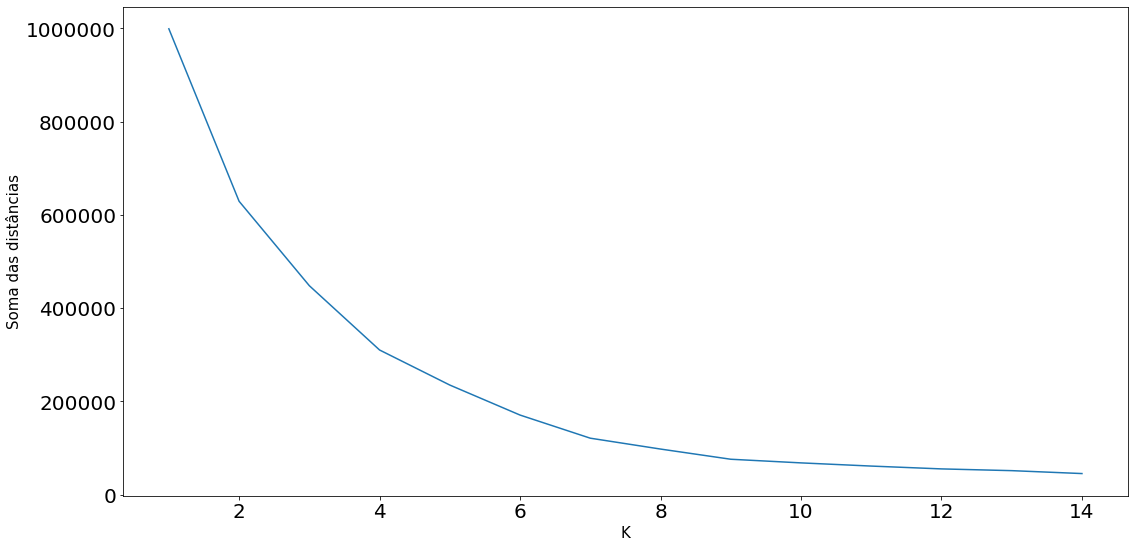

In [122]:
plt.figure(figsize=(18,9))
plt.plot([None]+inertias)
plt.xlabel("K", fontsize=15)
plt.ylabel("Soma das distâncias", fontsize=15)

plt.tick_params(axis='both', which='major', labelsize=20)

### Fit

In [11]:
clt_final = cluster.KMeans(n_clusters=9)

In [12]:
clt_final.fit(df_stats)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Visualizations

#### 2D

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_stats)
reduced = pca.transform(df_stats)

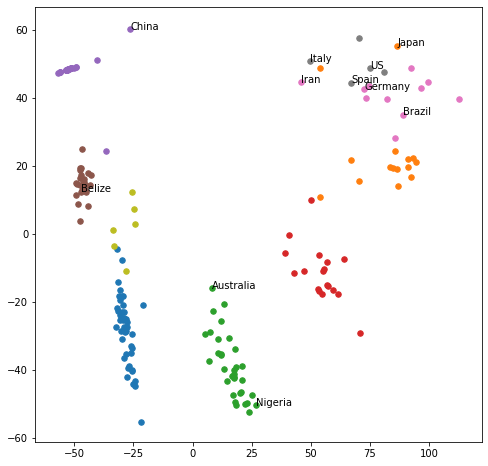

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
for i in range(9):
    ax.scatter(reduced[clt_final.labels_ == i,0], reduced[clt_final.labels_ == i,1], s=30)
    
for i, txt in enumerate(df_stats.index):
    if txt in ["US", "Italy", "China", "Brazil", "Iran", "Germany", "Japan", "Belize", "Australia", "Spain", "Nigeria"]:
        ax.annotate(txt, (reduced[i,0], reduced[i,1]))

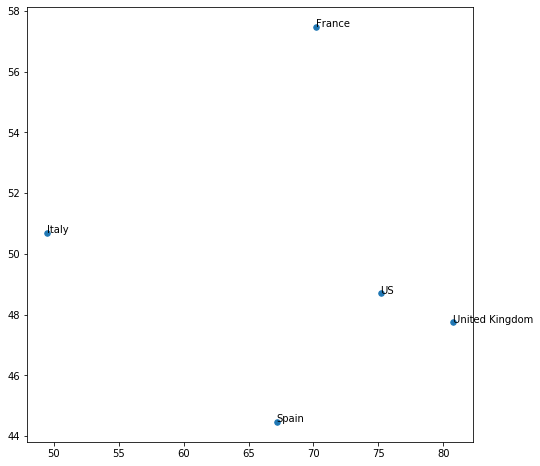

In [16]:
country_name = "US"

fig, ax = plt.subplots(figsize=(8,8))

selected_cluster = clt_final.predict(df_stats.iloc[df_stats.index==country_name])

ax.scatter(reduced[clt_final.labels_ == selected_cluster,0], reduced[clt_final.labels_ == selected_cluster,1], s=30)
    
for txt, (x, y) in zip(df_stats.iloc[clt_final.labels_ == selected_cluster].index, reduced[clt_final.labels_ == selected_cluster]):
    ax.annotate(txt, (x, y))
    

#### 3D

In [127]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(df_stats)
reduced = pca.transform(df_stats)

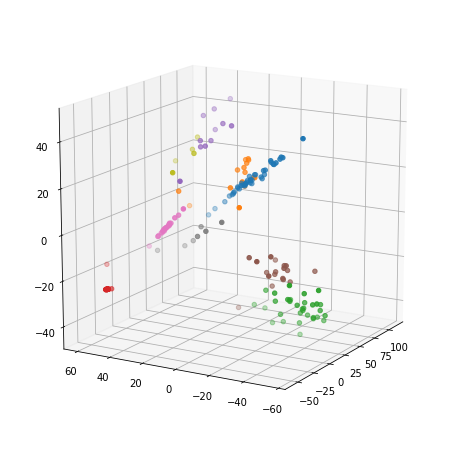

In [128]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


for i in range(9):
    ax.scatter(reduced[clt_final.labels_ == i,0], 
               reduced[clt_final.labels_ == i,1], 
               reduced[clt_final.labels_ == i,2])

ax.view_init(15, 210)